# Recomendador de inversiones inmoviliarias

## Datos origen:

- [indicadores](datasets/gem_indicadores.csv)
- [pisos](datasets/idealista_datafile.csv)


## Tareas:

1. Asignar precio estadístico de alquiler y compraventa a cada inmueble basado en su barrio o distrito
1. Crear una puntuación para el precio de compra para cada inmueble de 0 a 1 en función del precio estadístico de compra de cada barrio o distrito
1. Crear una puntuación para el precio de alquiler para cada inmueble de 0 a 1 en función del precio estadístico de alquiler de cada barrio o distrito
1. Calcular la tasa de retorno de cada inmueble en función del precio de compra y el precio de alquiler
1. Crear una puntuación final para cada inmueble de 0 a 1 en función de las puntuaciones anteriores


In [6]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore
import warnings
warnings.filterwarnings('ignore')

pisos = pd.read_csv('datasets/idealista_datafile.csv')
indicadores = pd.read_csv('datasets/gen_indicadores.csv')

# convertir los campos price y price_old a enteros, interpretando el punto como separador de miles
pisos[['price','price_old']] = (pisos[['price','price_old']].fillna(0)).astype(int).replace(0, np.nan)


display(pisos.info())
display(indicadores.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 281 entries, 0 to 280
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   link         281 non-null    object 
 1   type_v       281 non-null    object 
 2   address      281 non-null    object 
 3   town         281 non-null    object 
 4   price        281 non-null    int64  
 5   price_old    15 non-null     float64
 6   info         281 non-null    object 
 7   description  281 non-null    object 
 8   tags         16 non-null     object 
 9   agent        0 non-null      float64
 10  created      281 non-null    object 
dtypes: float64(2), int64(1), object(8)
memory usage: 24.3+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 41 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             84 non-null     int64  
 1   nombre                         84 non-null     object 
 2   sup_id                         84 non-null     int64  
 3   sup_nombre                     84 non-null     object 
 4   tipo                           84 non-null     object 
 5   precio_venta_1y                84 non-null     float64
 6   superficie_venta_1y            84 non-null     float64
 7   elasticidad_1y                 84 non-null     float64
 8   precio_alquiler_1y             84 non-null     float64
 9   rentabilidad_1y                84 non-null     float64
 10  grow_acu_alquiler_1y           84 non-null     float64
 11  grow_acu_venta_1y              84 non-null     float64
 12  grow_acu_superficie_venta_1y   84 non-null     float

None

In [7]:
from src.report.realty_report import RealtyReport   

pisos['town'] = pisos['town'].map(RealtyReport.get_town)
pisos['description'] = pisos['description'].map(RealtyReport.clean_description)
pisos[['type_v','address', 'description']] = pisos[['type_v','address', 'description']].applymap(RealtyReport.estandarizar)
pisos['n_hab'] = pisos['info'].map(lambda x: RealtyReport.find_min_int(x, RealtyReport.RX_HAB)).astype('Int64')
pisos['sup_m2'] = pisos['info'].map(lambda x: RealtyReport.find_min_int(x, RealtyReport.RX_M2)).astype('Int64')

pisos



,link,type_v,address,town,price,price_old,info,description,tags,agent,created,n_hab,sup_m2
0,https://www.idealista.com/inmueble/106924638/,piso,"calle de l'om, el raval, barcelona",el raval,100000,NaN,"['3 hab.', '50 m²', 'Entreplanta exterior sin ...",piso de 50 m2 en calle om totalmente a reforma...,NaN,NaN,2025-01-01 12:43:17,3,50
1,https://www.idealista.com/inmueble/106923754/,piso,"calle de l'om, el raval, barcelona",el raval,100000,NaN,"['3 hab.', '49 m²', 'Entreplanta exterior sin ...","piso de 49m² en venta en calle om, en ciutat v...",NaN,NaN,2025-01-01 12:43:17,3,49
2,https://www.idealista.com/inmueble/106910818/,estudio,"calle de muntaner, sant antoni, barcelona",sant antoni,100000,NaN,"['17 m²', 'Planta 4ª exterior con ascensor']",vivienda en un solo ambiente tipo loft! tranqu...,NaN,NaN,2025-01-01 12:43:17,<NA>,17
3,https://www.idealista.com/inmueble/104891324/,piso,"calle de les carretes, el raval, barcelona",el raval,92000,NaN,"['1 hab.', '44 m²', 'Planta 1ª sin ascensor']",oportunidad solo para inversores. debido al es...,NaN,NaN,2025-01-01 12:43:17,1,44
4,https://www.idealista.com/inmueble/106912666/,piso,"la trinitat nova, barcelona",la trinitat nova,66660,NaN,"['2 hab.', '49 m²', ' exterior sin ascensor']",no cobramos comision al comprador. inmueble oc...,NaN,NaN,2025-01-01 12:43:17,2,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...
276,https://www.idealista.com/inmueble/101539089/,estudio,"calle de duran i borrell, el coll, barcelona",el coll,75000,NaN,"['30 m²', 'Planta 1ª interior sin ascensor']",importante:•estudio con cedula!•finca afectada...,NaN,NaN,2025-01-01 12:43:56,<NA>,30
277,https://www.idealista.com/inmueble/101240861/,estudio,"calle de catania, el besos, barcelona",el besos,82000,NaN,['48 m²'],¡oportunidad para comprar tu piso! situado en ...,NaN,NaN,2025-01-01 12:43:56,<NA>,48
278,https://www.idealista.com/inmueble/97594414/,estudio,"serra, el gotic, barcelona",el gotic,85000,NaN,"['26 m²', 'Bajo interior sin ascensor']",excelente estudio reformado en pleno barrio go...,NaN,NaN,2025-01-01 12:43:56,<NA>,26
279,https://www.idealista.com/inmueble/88456465/,piso,"calle de la reina amalia, el raval, barcelona",el raval,89000,NaN,"['2 hab.', '46 m²', ' sin ascensor']",¿quieres comprar piso de 2 habitaciones en bar...,NaN,NaN,2025-01-01 12:43:56,2,46


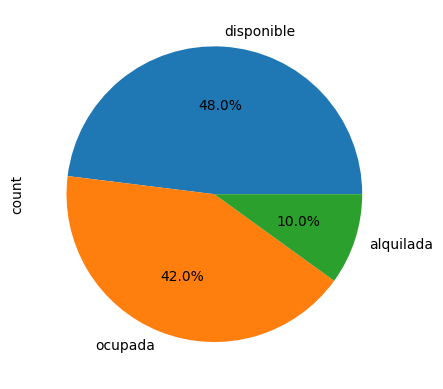

    disponibilidad                                                                                                                                                                                                                                                                                                                                                             description
0       disponible                                                                                                                                                                                                                           piso de 50 m2 en calle om totalmente a reformar.finca de 1840 sin ascensor.dispone de salon, 3 habitaciones, cocina y 1 bano. suelos de gres.
1       disponible                                                   piso de 49m² en venta en calle om, en ciutat vella.primera planta real en finca sin ascensor.piso exterior con balcon.tiene 3 habitaciones, cocina y salon comedor.precisa de

In [8]:
pisos['disponibilidad'] = pisos['description'].map(RealtyReport.get_occupation)


pisos['disponibilidad'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.show()
print(pisos[pisos['disponibilidad'] == 'disponible'][['disponibilidad','description']].to_string())


In [9]:

# Initialize tags column if it doesn't exist
pisos['tags'] = pisos['tags'].fillna('')
pisos['tags'] = pisos['description'].map(RealtyReport.extract_tags)

display(pisos[['description', 'tags']])


,description,tags
0,piso de 50 m2 en calle om totalmente a reforma...,"[a reformar, sin ascensor]"
1,"piso de 49m² en venta en calle om, en ciutat v...","[balcon, metro, sin ascensor, piso exterior, d..."
2,vivienda en un solo ambiente tipo loft! tranqu...,"[de ascensor, de cedula]"
3,oportunidad solo para inversores. debido al es...,"[oportunidad, inversores]"
4,no cobramos comision al comprador. inmueble oc...,"[oportunidad, inversores, terraza]"
...,...,...
276,importante:•estudio con cedula!•finca afectada...,"[estudio, local, con cedula]"
277,¡oportunidad para comprar tu piso! situado en ...,[oportunidad]
278,excelente estudio reformado en pleno barrio go...,"[estudio, inversion, estudio reformado]"
279,¿quieres comprar piso de 2 habitaciones en bar...,[oportunidad]


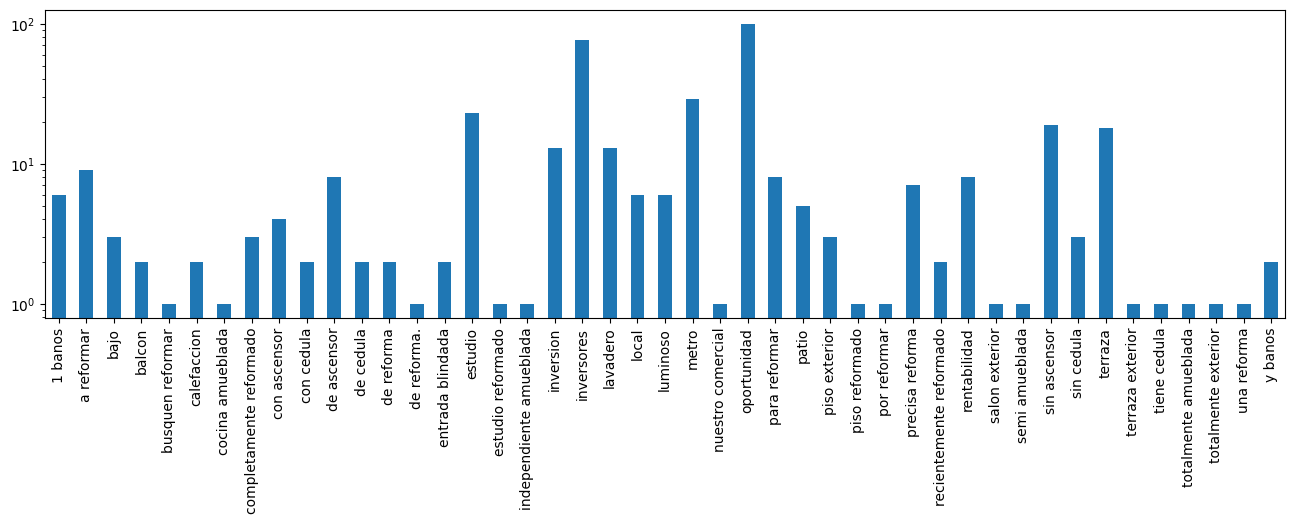

In [10]:

# Split tags into individual words and count occurrences
tag_counts = pd.Series([word.strip() for tags_list in pisos['tags'] for word in tags_list if word.strip()]).value_counts()
# Plot the tag counts
tag_counts.sort_index().plot(kind='bar', figsize=(16,4), logy=True)
plt.show()


In [11]:

places = indicadores['nombre'].unique().tolist()

pisos[['barrio', 'barrio_ratio']] = pd.DataFrame(pisos['town'].map(lambda x: RealtyReport.map_place(x, places)).tolist(), index=pisos.index)
display(pisos.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 281 entries, 0 to 280
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   link            281 non-null    object 
 1   type_v          281 non-null    object 
 2   address         281 non-null    object 
 3   town            281 non-null    object 
 4   price           281 non-null    int64  
 5   price_old       15 non-null     float64
 6   info            281 non-null    object 
 7   description     281 non-null    object 
 8   tags            281 non-null    object 
 9   agent           0 non-null      float64
 10  created         281 non-null    object 
 11  n_hab           247 non-null    Int64  
 12  sup_m2          281 non-null    Int64  
 13  disponibilidad  281 non-null    object 
 14  barrio          281 non-null    object 
 15  barrio_ratio    281 non-null    float64
dtypes: Int64(2), float64(3), int64(1), object(10)
memory usage: 35.8+ KB


None

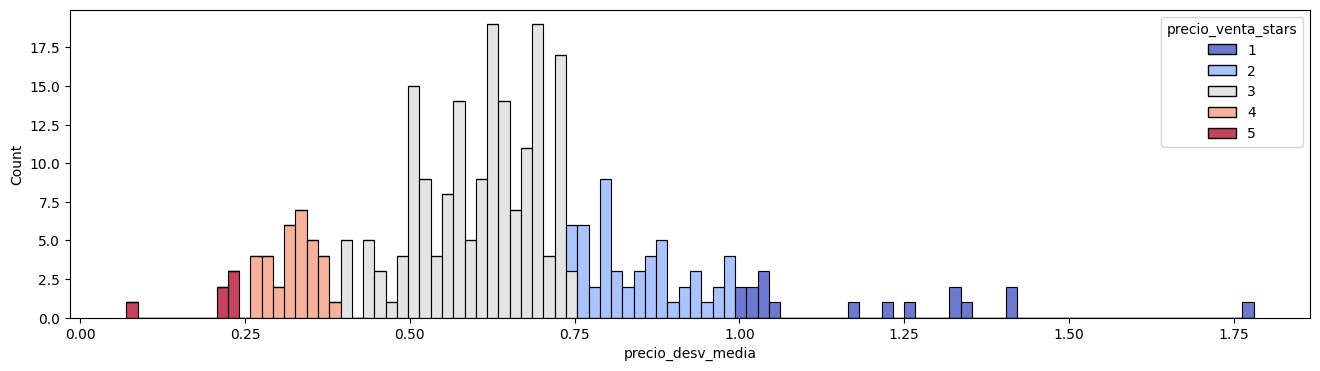

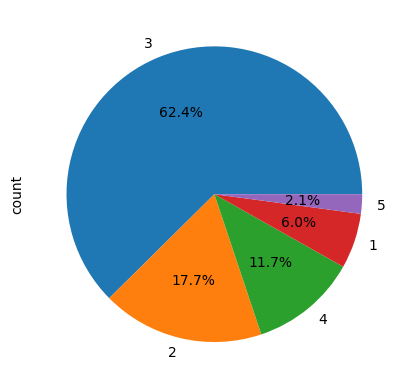

In [12]:
informe = pd.merge(pisos, indicadores, left_on='barrio', right_on='nombre', how='left')

# calcular el precio por metro cuadrado 
informe['precio_m2'] = informe.apply(lambda row: RealtyReport.get_price_m2(row['price'], row['sup_m2']), axis=1)

# calcular la desviación de precio_m2 sobre precio_venta_1y (medio del último año)
informe['precio_desv_media'] = informe.apply(lambda row: RealtyReport.get_price_desv_media(row['precio_m2'], row['precio_venta_1y']), axis=1)

# calcular la puntuación del precio de compra, máximo 5 stars, sobre el precio medio de venta del último (precio_venta_1y) 
informe['precio_venta_stars'] = informe.apply(lambda row: RealtyReport.get_price_stars(row['precio_desv_media']), axis=1)



plt.figure(figsize=(16,4))
sns.histplot(data=informe, x='precio_desv_media', bins=100, hue='precio_venta_stars', palette='coolwarm', multiple='stack')
plt.show()


# [(informe['precio_venta_stars'].fillna(0) > 2) & (informe['precio_venta_stars'].fillna(0) < 3)]
informe[['price', 'sup_m2', 'precio_m2', 'precio_venta_1y','precio_desv_media', 'precio_venta_stars']].sort_values(by='precio_desv_media', ascending=False)

informe['precio_venta_stars'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.show()


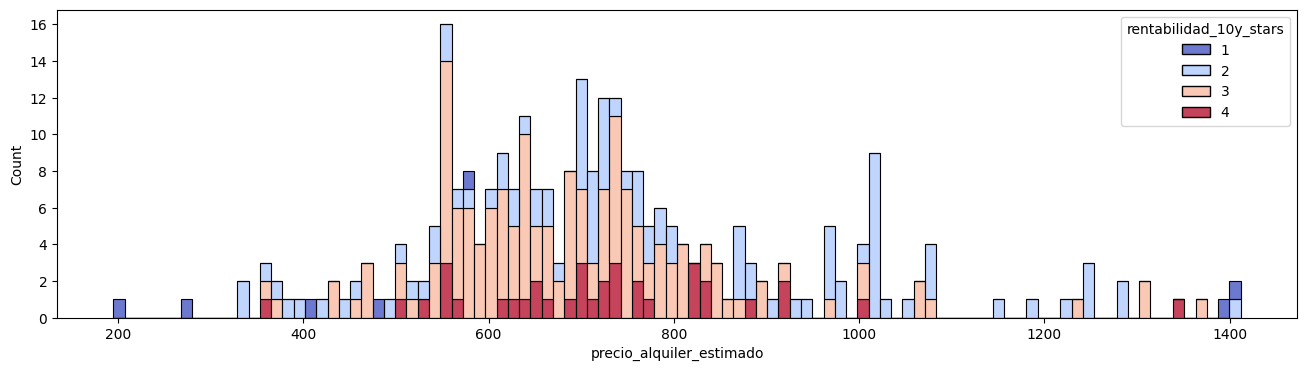

In [13]:
# display(informe.info())

informe['precio_alquiler_estimado'] = informe.apply(lambda row: RealtyReport.get_price_alquiler_estimado(row['precio_alquiler_1y'], row['sup_m2']), axis=1)
informe['precio_venta_estimado'] = informe.apply(lambda row: RealtyReport.get_price_venta_estimado(row['precio_venta_1y'], row['sup_m2']), axis=1)

plt.figure(figsize=(16,4))
sns.histplot(data=informe[informe['sup_m2'] <150], x='precio_alquiler_estimado', bins=100, palette='coolwarm', hue='rentabilidad_10y_stars' , multiple='stack')
plt.show()


# display(informe[informe['sup_m2'] >150].sort_values(by='sup_m2', ascending=False))

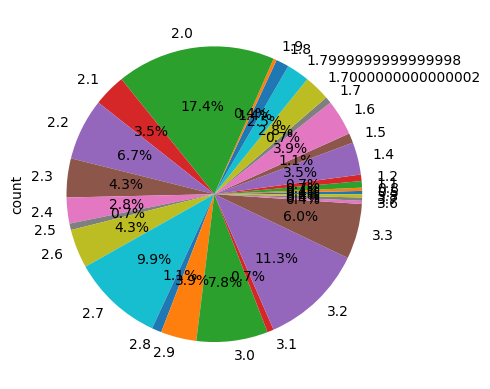

In [14]:
# weights = {
#     'precio_venta_stars': 0.6,        # Precio competitivo es el factor más importante
#     'rentabilidad_10y_stars': 0.2,  # Rentabilidad actual
#     'grow_acu_alquiler_10y_stars': 0.1, # Crecimiento histórico de alquileres
#     'grow_acu_venta_10y_stars': 0.1     # Crecimiento histórico de ventas
# }


# informe['global_score_stars'] = round((
#      informe['precio_venta_stars'] * weights['precio_venta_stars'] \
#     + informe['rentabilidad_10y_stars'] * weights['rentabilidad_10y_stars'] \
#     + informe['grow_acu_alquiler_10y_stars'] * weights['grow_acu_alquiler_10y_stars'] \
#     + informe['grow_acu_venta_10y_stars'] * weights['grow_acu_venta_10y_stars']),1)

# # Restar 0.5 estrellas si la disponibilidad es "ocupada"
# informe.loc[informe['disponibilidad'] == 'ocupada', 'global_score_stars'] = informe['global_score_stars'] - 1

informe['global_score_stars'] = informe.apply(lambda row: RealtyReport.get_global_score_stars(row['precio_venta_stars'], row['rentabilidad_10y_stars'], row['grow_acu_venta_10y_stars'], row['grow_acu_alquiler_10y_stars'], row['disponibilidad']), axis=1)


informe['global_score_stars'].value_counts().sort_index().plot(kind='pie', autopct='%1.1f%%')
plt.show()


| Column                          | Dtype     | Descripción                                        |
|---------------------------------|-----------|---------------------------------------------------|
| link                            | object    | Enlace a la publicación del inmueble             |
| type_v                          | object    | Tipo de vivienda (casa, apartamento, etc.)       |
| address                         | object    | Dirección completa del inmueble                  |
| town                            | object    | Ciudad o localidad donde se encuentra el inmueble|
| price                           | int64     | Precio actual del inmueble                       |
| price_old                       | float64   | Precio anterior registrado                       |
| info                            | object    | Información adicional sobre el inmueble          |
| description                     | object    | Descripción del inmueble                         |
| tags                            | object    | Etiquetas asociadas al inmueble                  |
| agent                           | object    | Información sobre el agente inmobiliario         |
| created                         | object    | Fecha de creación del registro                   |
| n_hab                           | Int64     | Número de habitaciones                           |
| sup_m2                          | Int64     | Superficie en metros cuadrados                   |
| disponibilidad                  | object    | Estado de disponibilidad del inmueble            |
| barrio                          | object    | Barrio donde se encuentra el inmueble            |
| barrio_ratio                    | float64   | Ratio de certeza de la identificación del barrio |
| id                              | int64     | Identificador único del barrio                   |
| nombre                          | object    | Nombre del barrio                                |
| sup_id                          | int64     | Identificador de la localidad del barrio         |
| sup_nombre                      | object    | Nombre de la localidad del barrio                 |
| tipo                            | object    | Clasificación del tipo de localidad              |
| precio_venta_10y                | float64   | Precio promedio de venta en los últimos 10 años en el barrio |
| superficie_venta_10y            | float64   | Superficie promedio vendida en los últimos 10 años en el barrio |
| elasticidad_10y                 | float64   | Elasticidad del mercado en 10 años en el barrio              |
| precio_venta_1y                 | float64   | Precio promedio de venta en el último año en el barrio         |
| superficie_venta_1y             | float64   | Superficie promedio vendida en el último año en el barrio     |
| elasticidad_1y                  | float64   | Elasticidad del mercado en el último año en el barrio         |
| precio_venta_5y                 | float64   | Precio promedio de venta en los últimos 5 años en el barrio   |
| superficie_venta_5y             | float64   | Superficie promedio vendida en los últimos 5 años en el barrio |
| elasticidad_5y                  | float64   | Elasticidad del mercado en 5 años en el barrio               |
| precio_alquiler_10y             | float64   | Precio promedio de alquiler en los últimos 10 años en el barrio |
| rentabilidad_10y                | float64   | Rentabilidad promedio en los últimos 10 años en el barrio     |
| precio_alquiler_1y              | float64   | Precio promedio de alquiler en el último año en el barrio     |
| rentabilidad_1y                 | float64   | Rentabilidad promedio en el último año en el barrio               |
| precio_alquiler_5y              | float64   | Precio promedio de alquiler en los últimos 5 años en el barrio   |
| rentabilidad_5y                 | float64   | Rentabilidad promedio en los últimos 5 años en el barrio      |
| grow_acu_alquiler_10y           | float64   | Crecimiento acumulado del alquiler en 10 años en el barrio    |
| grow_acu_venta_10y              | float64   | Crecimiento acumulado de ventas en 10 años en el barrio       |  
| grow_acu_superficie_venta_10y   | float64   | Crecimiento acumulado de superficie vendida en 10 años en el barrio |
| grow_acu_alquiler_1y            | float64   | Crecimiento acumulado del alquiler en el último año en el barrio |
| grow_acu_venta_1y               | float64   | Crecimiento acumulado de ventas en el último año en el barrio |
| grow_acu_superficie_venta_1y    | float64   | Crecimiento acumulado de superficie vendida en el último año en el barrio |
| grow_acu_alquiler_5y            | float64   | Crecimiento acumulado del alquiler en los últimos 5 años en el barrio |
| grow_acu_venta_5y               | float64   | Crecimiento acumulado de ventas en los últimos 5 años en el barrio |
| grow_acu_superficie_venta_5y    | float64   | Crecimiento acumulado de superficie vendida en los últimos 5 años en el barrio |
| elasticidad_10y_stars           | int64     | Puntuación de elasticidad del mercado en 10 años en el barrio |
| rentabilidad_10y_stars          | int64     | Puntuación de rentabilidad en 10 años en el barrio |
| grow_acu_alquiler_10y_stars     | int64     | Puntuación de crecimiento de alquiler en 10 años en el barrio |
| grow_acu_venta_10y_stars        | int64     | Puntuación de crecimiento de ventas en 10 años en el barrio |
| precio_m2                       | int64     | Precio por metro cuadrado del inmueble                    |
| precio_desv_media               | float64   | Desviación del precio respecto a la media en el barrio   |
| precio_venta_stars              | int64     | Puntuación del precio de venta del inmueble            |
| precio_alquiler_estimado        | Float64   | Precio estimado de alquiler del inmueble               |
| precio_venta_estimado           | Float64   | Precio estimado de venta del inmueble                |
| global_score_stars               | Float64   | Puntuación global del inmueble                        |


In [15]:
print(informe.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 63 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   link                           282 non-null    object 
 1   type_v                         282 non-null    object 
 2   address                        282 non-null    object 
 3   town                           282 non-null    object 
 4   price                          282 non-null    int64  
 5   price_old                      15 non-null     float64
 6   info                           282 non-null    object 
 7   description                    282 non-null    object 
 8   tags                           282 non-null    object 
 9   agent                          0 non-null      float64
 10  created                        282 non-null    object 
 11  n_hab                          247 non-null    Int64  
 12  sup_m2                         282 non-null    Int

In [16]:
from IPython.display import HTML


columns = ['link', 'type_v', 'address', 'town', 'price', 'price_old', 'info',
       'description', 'tags', 'agent', 'created', 'n_hab', 'sup_m2',
       'disponibilidad', 'barrio', 'barrio_ratio', 'id', 'nombre', 'sup_id',
       'sup_nombre', 'tipo', 'precio_venta_10y', 'superficie_venta_10y',
       'elasticidad_10y', 'precio_venta_1y', 'superficie_venta_1y',
       'elasticidad_1y', 'precio_venta_5y', 'superficie_venta_5y',
       'elasticidad_5y', 'precio_alquiler_1y', 'rentabilidad_1y',
       'precio_alquiler_5y', 'rentabilidad_5y', 'precio_alquiler_10y',
       'rentabilidad_10y', 'grow_acu_alquiler_1y', 'grow_acu_venta_1y',
       'grow_acu_superficie_venta_1y', 'grow_acu_alquiler_5y',
       'grow_acu_venta_5y', 'grow_acu_superficie_venta_5y',
       'grow_acu_alquiler_10y', 'grow_acu_venta_10y',
       'grow_acu_superficie_venta_10y', 'elasticidad_10y_stars',
       'rentabilidad_10y_stars', 'grow_acu_alquiler_10y_stars',
       'grow_acu_venta_10y_stars', 'precio_m2', 'precio_desv_media',
       'precio_venta_stars', 'precio_alquiler_estimado',
       'precio_venta_estimado', 'global_score_stars']

informe[columns].to_csv('datasets/gen_informe.csv', index=False)


for _, row in informe[informe['global_score_stars'] > 3].sort_values(by='global_score_stars', ascending=False).iterrows():
   
#    display(row.to_dict())
   display(HTML(f"""<h3>{row['type_v']} en <a href="{row['link']}">{row['address']}</a></h3>
                <b>Estrellas Globales</b>: {row['global_score_stars']}<br>
                <b>Estrellas de Precio</b>: {row['precio_venta_stars']}<br>
                <b>Estrellas de Rentabilidad</b>: {row['rentabilidad_10y_stars']}<br>
                <b>Rentabilidad</b>: {row['rentabilidad_10y'] *100:.2f} %<br>
                <b>precio</b>: {row['price']} €<br>
                <b>metros cuadrados</b>: {row['sup_m2']} m2<br>
                <b>precio_m2</b>: {row['precio_m2']} €/m2 ({row['precio_venta_stars']} estrellas) ya que es un {row['precio_desv_media']*100:.0f}% del precio medio de venta de {row['nombre']} : {row['precio_venta_1y']:.0f} €/m2<br>
                <b>precio_alquiler_estimado</b>: {row['precio_alquiler_estimado']:.0f} €/mes<br>
                <b>precio_venta_estimado</b>: {row['precio_venta_estimado']:.0f} €<br>
                <b>habitaciones</b>: {row['n_hab']}<br>
                <b>descripcion</b>: {row['description']}<br>
                <b>tags</b>: {row['tags']}<br>
                <b>barrio</b>: {row['barrio']}<br>
                <b>creado</b>: {row['created']}<br>
                <b>disponibilidad</b>: {row['disponibilidad']}<br>
                """))
